In [1]:
from datetime import date
print('created 2024-04-07')
print("last updated", date.today())

created 2024-04-07
last updated 2024-08-23


In [2]:
import pickle
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'

norm_cts = pd.read_csv(outpath+"data/integrated_DESeq2_output_norm_cts.csv", index_col=0)

bcs = list(norm_cts.index)
num_reps = 10

intronless_barcodes = ['ACTATCTAACCAAACACA', 
                       'ACTCCTTCAATCCCATCA',
                       'CATAACTTAATTATTTTA',
                       'TACATTATCTCTTCATAC']

UbC_bc = 'ATACCATAACTACCCACT'
spike_in_bcs = intronless_barcodes+[UbC_bc]

intless_mask = np.array([b in intronless_barcodes for b in bcs])
pos_ctrl_mask = np.array([b==UbC_bc for b in bcs])

In [3]:
GFP_counts = norm_cts.values[:,:num_reps]    # includes unspliced
dTom_counts = norm_cts.values[:,num_reps:num_reps*2]
readcounts = GFP_counts + dTom_counts
pseudo_count = 1e-10
raw_IME_scores = np.log2((GFP_counts+ pseudo_count)/(dTom_counts+ pseudo_count))

Here's an approach that could be taken to simulate these data:



1. Generate a shared `expected_ratio` for all replicates within each iteration.
2. Use the same `total_reads` for `rep1` and `rep2`, and another set of `total_reads` for `rep3` and `rep4`, to ensure correlation within these groups.
3. To generate `rep2` and `rep4`, instead of adding noise, you could simulate the foreground and background reads separately for `rep1` and `rep3`, then derive `rep2` and `rep4` from these by sharing the foreground reads but sampling the background reads independently.




for each intron: 
- IME score is randomly sampled from log2(-0.05, 0.05)  ~ (effect size 0.965-1.035)
- total reads/intron/rep sampled from (0,10000) 
- dTom reads sampled from binomial with n=total reads and p=score/(1+score) to approximate baseline expression being consistent *within* a transfection.
- this is done once for reps 1+2 and once for reps 3+4.
- GFP reads independently sampled from the same n and p=(1-p) to introduce read count noise

In [4]:
def add_Rvalue(xdata,ydata):
    coef, _ = scipy.stats.pearsonr(xdata,ydata)
    #plt.annotate(f'$\\rho$={coef:.3f}', xy=(0.85, 0.05), xycoords='axes fraction', fontsize=8)
    #plt.annotate(f'$R^2$={coef**2:.2f}', xy=(0.4, 0.05), xycoords='axes fraction')
    plt.annotate(f'$R$={coef:.2f}', xy=(0.65, 0.05), xycoords='axes fraction')
    return(coef)

def add_intless(xdata,ydata):
    plt.scatter(xdata[intless_mask], ydata[intless_mask], s=20, marker='*', c='orange')

In [5]:
empirical_readcount_dist = readcounts.flatten()

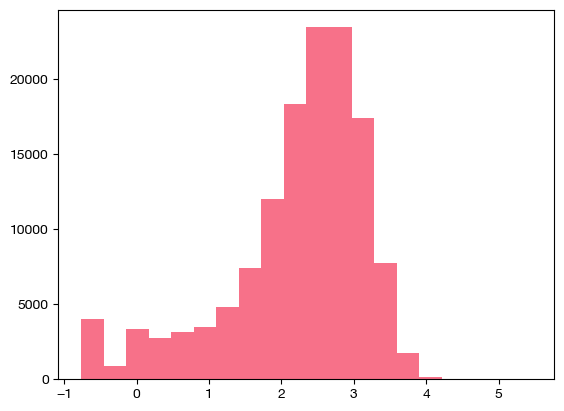

In [6]:
plt.hist(np.log10(empirical_readcount_dist[empirical_readcount_dist!=0]),
        bins=20)
plt.show()

In [7]:
def simulate_read_counts(foreground_reads, background_reads):
    
    # Avoid division by zero or log of zero by adding a small number (pseudo count)
    pseudo_count = 1
    
    if noise==True:
        f_noise = max(10, (foreground_reads+1)*noisiness)
        b_noise = max(10, (background_reads+1)*noisiness)
        foreground_reads = foreground_reads + int(np.random.normal(0,f_noise)) #+ int(np.random.uniform(-f_noise,f_noise)) #
        background_reads = background_reads + int(np.random.normal(0,b_noise)) #+ int(np.random.uniform(-b_noise,b_noise)) #
        
    # Calculate the observed ratio and its log2
    observed_ratio = (max(foreground_reads,pseudo_count)) / (max(background_reads,pseudo_count))
    
    return np.log2(observed_ratio)

In [9]:
# final params used in paper:

noise = True
noisiness = 0.25
txf_noise = True
txf_noisiness = 1
txf_noise_sparsity = 9

read count filter = 1
read count filter = 10
read count filter = 50
read count filter = 100
read count filter = 500


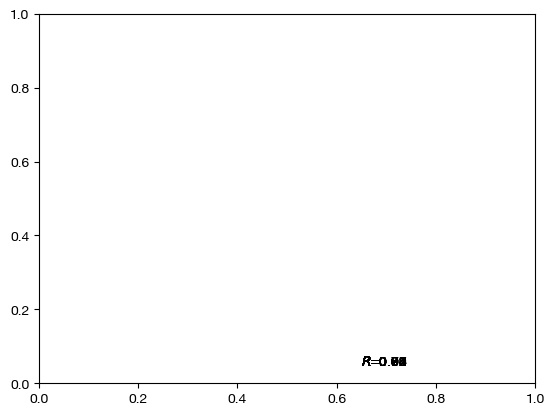

In [10]:
# collect data for plotting
ranges = [0.001,0.01,0.1,0.2,0.5,1,1.5,2]
#ranges = [0.05,0.1,0.15,0.2,0.25,0.3]
filters = [1,10,50,100,500]
#ranges, filters = [0.2,0.3], [10,100]

mean_coefs = {f:{r:{'inter':0,'intra':0} for r in ranges} for f in filters}
real_coefs = {f:[] for f in filters}

for filter in filters:
    print(f'read count filter = {filter}')
    for log_ratio_range in ranges:
        
        rep = {i:[] for i in [1,2,3,4]} 
        sim_reads = {i:[] for i in [1,2,3,4]}
        dTom = {i:0 for i in [1,2,3,4]}
        GFP = {i:0 for i in [1,2,3,4]}
        
        for k in range(10000):
            # generate IME score
            if k>=4:
                expected_IME = 2**(np.random.normal(0,log_ratio_range))
                p = expected_IME / (1 + expected_IME)
    
            # add intronless??
            elif k<4:
                expected_IME = 2**(np.random.normal(-5,0.2))
                p = expected_IME / (1 + expected_IME)
            
            for i in [1,3]:      
                # Generate total reads for the first pair
                if k>=4:
                    total_reads = int(random.choice(empirical_readcount_dist))
                elif k<4:
                    total_reads = int(max(empirical_readcount_dist))
    
                # simulate transfection-specific noise
                if txf_noise==True:
                    t_noise = (total_reads+1)*txf_noisiness
                    dTom_noise = random.choice([0]*txf_noise_sparsity+[int(np.random.normal(0,t_noise))])
                    GFP_noise = random.choice([0]*txf_noise_sparsity+[int(np.random.normal(0,t_noise))])
                else:
                    dTom_noise , GFP_noise = 0, 0
                
                # From this total readcount, sample dTomato reads based on the expected ratio
                dTom[i] = dTom[i+1] = max(0,np.random.binomial(n=total_reads, p=(1-p))+dTom_noise)
                
                # Sample foreground reads independently for rep1 and rep2
                GFP[i] = max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                GFP[i+1] = max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                
                # store readcounts for filtering later
                sim_reads[i].append(GFP[i]+dTom[i])
                sim_reads[i+1].append(GFP[i+1]+dTom[i+1])
                
                # calculate and store IME scores
                rep[i].append(simulate_read_counts(GFP[i],dTom[i]))
                rep[i+1].append(simulate_read_counts(GFP[i+1],dTom[i+1]))
    
        # filter simulation data the same way i filter actual data
        mask=(np.array(sim_reads[1])>filter)&(np.array(sim_reads[2])>filter)&(np.array(sim_reads[3])>filter)&(np.array(sim_reads[4])>filter)
        
        for i in [1,2,3,4]:
            rep[i] = np.array(rep[i])
    
        coefs = []
        for i,j in [(1,2),(3,4),(1,3),(1,4),(2,3),(2,4)]:
            coef, _ = scipy.stats.pearsonr(rep[i][mask],rep[j][mask])
            coefs.append(coef)
            
        mean_coefs[filter][log_ratio_range]['intra'] = (coefs[:2])
        mean_coefs[filter][log_ratio_range]['inter'] = (coefs[2:])
                                                       
        #print(f'log ratio range: {log_ratio_range:.3f}')
        #print(f'introns: {len(rep[1][mask])}')
    
    # actual data for comparison
    rep[1], rep[2], rep[3], rep[4] = raw_IME_scores[:,5], raw_IME_scores[:,6], raw_IME_scores[:,7], raw_IME_scores[:,8]
    mask = (readcounts[:,5]>filter)&(readcounts[:,6]>filter)&(readcounts[:,7]>filter)&(readcounts[:,8]>filter)
    for i,j,k in [(1,2,1),(3,4,3),(1,3,2),(2,3,4)]:
        real_coefs[filter].append(add_Rvalue(rep[i][mask], rep[j][mask]))

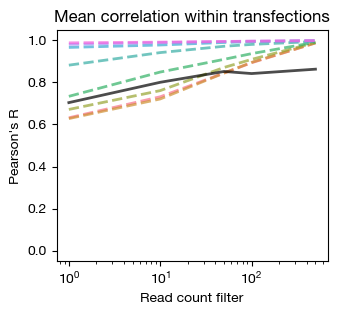

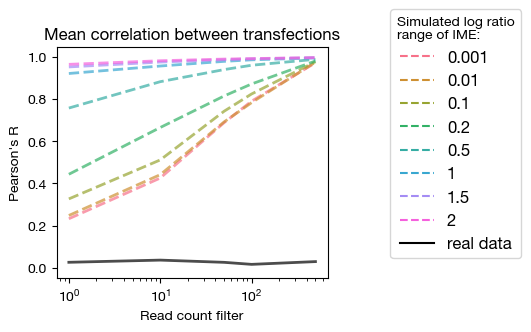

In [12]:
import seaborn as sns
sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

ranges = [0.001,0.01,0.1,0.2,0.5,1,1.5,2]
#ranges = [0.05,0.1,0.15,0.2,0.25,0.3]
filters = [1,10,50,100,500]
#filters = [1,10,25,50,75,100,200,350,500]
m = len(ranges)

plt.figure(figsize=(3.5,3))
# now plot relationships of coefs with cutoffs

plt.plot(0,0, linestyle='-', c='k', label='real data')

for i,r in enumerate(ranges):
    plt.plot(filters,[np.mean(mean_coefs[f][r]['intra']) for f in filters], linestyle='--', c=nicecolors(i,m), linewidth=2, alpha=0.7)
    plt.plot(0,0, linestyle='--', c=nicecolors(i,m), linewidth=2, alpha=0.7, label=f'{r}')
plt.plot(filters,[np.mean(real_coefs[f][:2]) for f in filters], c='k', linewidth=2, alpha=0.7)

plt.title('Mean correlation within transfections')
plt.xlabel('Read count filter')
plt.ylabel('Pearson\'s R')
#plt.ylim(0.68,0.93)
plt.xscale('log')
plt.show()

plt.figure(figsize=(3.5,3))
# now plot relationships of coefs with cutoffs

for i,r in enumerate(ranges):
    plt.plot(filters,[np.mean(mean_coefs[f][r]['inter']) for f in filters], linestyle='--', c=nicecolors(i,m), linewidth=2, alpha=0.7)
    plt.plot(0,0, linestyle='--', c=nicecolors(i,m), label=f'{r}')
plt.plot(filters,[np.mean(real_coefs[f][2:]) for f in filters], c='k', linewidth=2, alpha=0.7)

plt.plot(0,0, linestyle='-', c='k', label='real data')

plt.title('Mean correlation between transfections')
plt.xlabel('Read count filter')
plt.ylabel('Pearson\'s R')
plt.legend(title='Simulated log ratio\nrange of IME:',
           fontsize=12, bbox_to_anchor=(1.2,1.2))
plt.xscale('log')
#plt.ylim(-0.02,0.06)
plt.show()

In [13]:
mean_IME = 3.095666817996411
#for lrr in [0.001,0.01,0.1,0.2,0.3,0.4,0.5]:
for lrr in ranges:
    print(f'lrr={lrr}, 95% fold changes ~ {2**(mean_IME-(lrr*2)):.3f},{2**(mean_IME+(lrr*2)):.3f}')

lrr=0.05, 95% fold changes ~ 7.976,9.162
lrr=0.1, 95% fold changes ~ 7.442,9.820
lrr=0.15, 95% fold changes ~ 6.944,10.524
lrr=0.2, 95% fold changes ~ 6.479,11.280
lrr=0.25, 95% fold changes ~ 6.045,12.089
lrr=0.3, 95% fold changes ~ 5.640,12.957


read count filter = 10
log ratio range: 0.200
introns: 3665


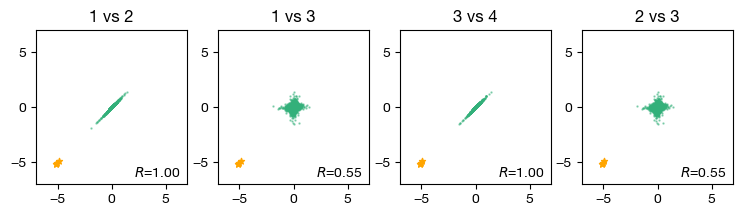

actual data:
introns: 3396


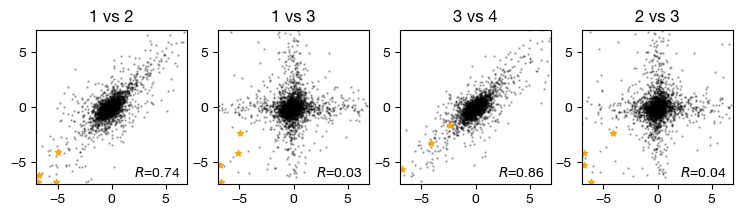

In [16]:
# FOR PLOTTING SCATTER PLOTS ONLY
ranges, filters = [0.2], [10]
plot_radius = 7

for filter in filters:
    print(f'read count filter = {filter}')
    for log_ratio_range in ranges:
        
        rep_s = {i:[] for i in [1,2,3,4]} 
        sim_reads_s = {i:[] for i in [1,2,3,4]}
        dTom_s = {i:0 for i in [1,2,3,4]}
        GFP_s = {i:0 for i in [1,2,3,4]}
        
        for k in range(10000):
            # generate IME score
            if k>=4:
                expected_IME = 2**(np.random.uniform(-log_ratio_range,log_ratio_range))
                p = expected_IME / (1 + expected_IME)
    
            # add intronless??
            elif k<4:
                expected_IME = 2**(np.random.normal(-5,0.2))
                p = expected_IME / (1 + expected_IME)
            
            for i in [1,3]:      
                # Generate total reads for the first pair
                if k>=4:
                    total_reads = int(random.choice(empirical_readcount_dist))
                elif k<4:
                    total_reads = int(max(empirical_readcount_dist))
    
                # simulate transfection-specific noise
                if txf_noise==True:
                    t_noise = (total_reads+1)*txf_noisiness
                    dTom_noise = random.choice([0]*5+[int(np.random.normal(0,t_noise))])
                    GFP_noise = random.choice([0]*5+[int(np.random.normal(0,t_noise))])
                else:
                    dTom_noise , GFP_noise = 0, 0
                
                # From this total readcount, sample dTomato reads based on the expected ratio
                dTom_s[i] = dTom_s[i+1] = max(0,np.random.binomial(n=total_reads, p=(1-p))+dTom_noise)
                
                # Sample foreground reads independently for rep1 and rep2
                GFP_s[i] =GFP_s[i+1] =  max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                #GFP[i+1] = max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                
                # store readcounts for filtering later
                sim_reads_s[i].append(GFP_s[i]+dTom_s[i])
                sim_reads_s[i+1].append(GFP_s[i+1]+dTom_s[i+1])
                
                # calculate and store IME scores
                rep_s[i].append(simulate_read_counts(GFP_s[i],dTom_s[i]))
                rep_s[i+1].append(simulate_read_counts(GFP_s[i+1],dTom_s[i+1]))
    
        # filter simulation data the same way i filter actual data
        mask=(np.array(sim_reads_s[1])>filter)&(np.array(sim_reads_s[2])>filter)&(np.array(sim_reads_s[3])>filter)&(np.array(sim_reads_s[4])>filter)
        
        for i in [1,2,3,4]:
            rep_s[i] = np.array(rep_s[i])
    
        coefs = []
        for i,j in [(1,2),(3,4),(1,3),(1,4),(2,3),(2,4)]:
            coef, _ = scipy.stats.pearsonr(rep_s[i][mask],rep_s[j][mask])
            coefs.append(coef)
                                                       
        print(f'log ratio range: {log_ratio_range:.3f}')
        print(f'introns: {len(rep_s[1][mask])}')
        
        # plot results of simulation
        plt.figure(figsize=(9,2))
        for i,j,k in [(1,2,1),(1,3,2),(2,3,4),(3,4,3)]:
            plt.subplot(1,4,k); plt.title(f"{i} vs {j}");plt.scatter(rep_s[i][mask], rep_s[j][mask], s=0.5, alpha=0.5, color=nicecolors(4,10))
            plt.xlim(-plot_radius,plot_radius);plt.ylim(-plot_radius,plot_radius)
            add_Rvalue(rep_s[i][mask], rep_s[j][mask])
            # add "intless"
            plt.scatter(rep_s[i][mask][:4], rep_s[j][mask][:4], s=20, marker='*', c='orange')
        plt.show()
    
    # plot actual data for comparison
    rep_s[1], rep_s[2], rep_s[3], rep_s[4] = raw_IME_scores[:,5], raw_IME_scores[:,6], raw_IME_scores[:,7], raw_IME_scores[:,8]
    mask = (readcounts[:,5]>filter)&(readcounts[:,6]>filter)&(readcounts[:,7]>filter)&(readcounts[:,8]>filter)
    print('actual data:')
    print(f'introns: {len(rep_s[1][mask])}')

    plt.figure(figsize=(9,2))
    for i,j,k in [(1,2,1),(3,4,3),(1,3,2),(2,3,4)]:
        plt.subplot(1,4,k); plt.title(f"{i} vs {j}");plt.scatter(rep_s[i][mask], rep_s[j][mask], s=0.5, alpha=0.3, color='black')
        plt.xlim(-plot_radius,plot_radius);plt.ylim(-plot_radius,plot_radius)
        add_Rvalue(rep_s[i][mask], rep_s[j][mask])
        add_intless(rep_s[i], rep_s[j])
    plt.show()


read count filter = 10
log ratio range: 0.100
introns: 3588


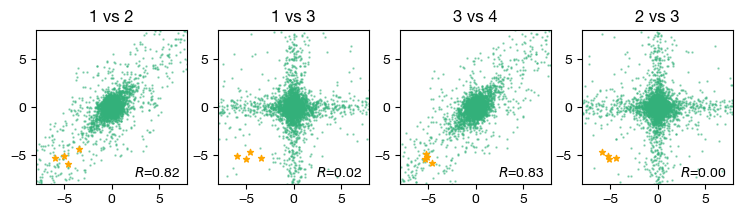

log ratio range: 0.300
introns: 3706


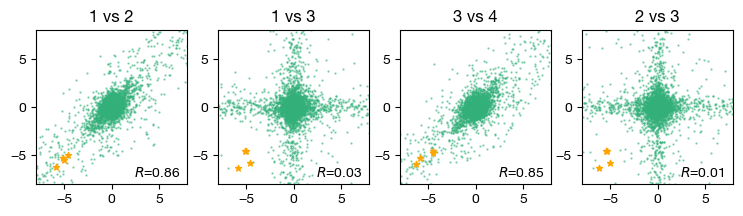

log ratio range: 0.500
introns: 3568


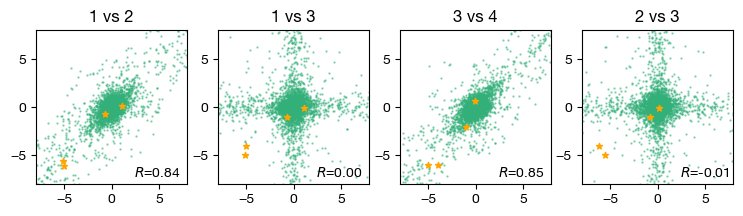

actual data:
introns: 3396


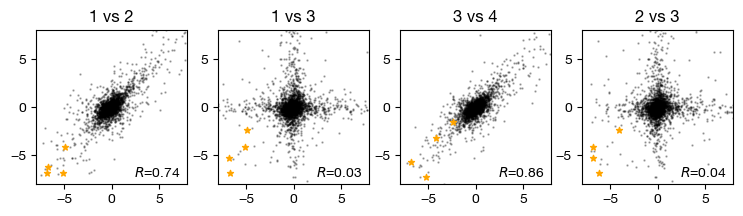

In [34]:
#plot without additional noise:

noise = True
noisiness = 0.25
txf_noise = True
txf_noisiness = 1
txf_noise_sparsity = 9

ranges, filters = [0.1, 0.3, 0.5], [10]
plot_radius = 8

for filter in filters:
    print(f'read count filter = {filter}')
    for log_ratio_range in ranges:
        
        rep_s = {i:[] for i in [1,2,3,4]} 
        sim_reads_s = {i:[] for i in [1,2,3,4]}
        dTom_s = {i:0 for i in [1,2,3,4]}
        GFP_s = {i:0 for i in [1,2,3,4]}
        
        for k in range(10000):
            # generate IME score
            if k>=4:
                expected_IME = 2**(np.random.uniform(-log_ratio_range,log_ratio_range))
                p = expected_IME / (1 + expected_IME)
    
            # add intronless??
            elif k<4:
                expected_IME = 2**(np.random.normal(-5,0.2))
                p = expected_IME / (1 + expected_IME)
            
            for i in [1,3]:      
                # Generate total reads for the first pair
                if k>=4:
                    total_reads = int(random.choice(empirical_readcount_dist))
                elif k<4:
                    total_reads = int(max(empirical_readcount_dist))
    
                # simulate transfection-specific noise
                if txf_noise==True:
                    t_noise = (total_reads+1)*txf_noisiness
                    dTom_noise = random.choice([0]*5+[int(np.random.normal(0,t_noise))])
                    GFP_noise = random.choice([0]*5+[int(np.random.normal(0,t_noise))])
                else:
                    dTom_noise , GFP_noise = 0, 0
                
                # From this total readcount, sample dTomato reads based on the expected ratio
                dTom_s[i] = dTom_s[i+1] = max(0,np.random.binomial(n=total_reads, p=(1-p))+dTom_noise)
                
                # Sample foreground reads independently for rep1 and rep2
                GFP_s[i] =GFP_s[i+1] =  max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                #GFP[i+1] = max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                
                # store readcounts for filtering later
                sim_reads_s[i].append(GFP_s[i]+dTom_s[i])
                sim_reads_s[i+1].append(GFP_s[i+1]+dTom_s[i+1])
                
                # calculate and store IME scores
                rep_s[i].append(simulate_read_counts(GFP_s[i],dTom_s[i]))
                rep_s[i+1].append(simulate_read_counts(GFP_s[i+1],dTom_s[i+1]))
    
        # filter simulation data the same way i filter actual data
        mask=(np.array(sim_reads_s[1])>filter)&(np.array(sim_reads_s[2])>filter)&(np.array(sim_reads_s[3])>filter)&(np.array(sim_reads_s[4])>filter)
        
        for i in [1,2,3,4]:
            rep_s[i] = np.array(rep_s[i])
    
        coefs = []
        for i,j in [(1,2),(3,4),(1,3),(1,4),(2,3),(2,4)]:
            coef, _ = scipy.stats.pearsonr(rep_s[i][mask],rep_s[j][mask])
            coefs.append(coef)
                                                       
        print(f'log ratio range: {log_ratio_range:.3f}')
        print(f'introns: {len(rep_s[1][mask])}')
        
        # plot results of simulation
        plt.figure(figsize=(9,2))
        for i,j,k in [(1,2,1),(1,3,2),(2,3,4),(3,4,3)]:
            plt.subplot(1,4,k); plt.title(f"{i} vs {j}");plt.scatter(rep_s[i][mask], rep_s[j][mask], s=0.5, alpha=0.5, color=nicecolors(4,10))
            plt.xlim(-plot_radius,plot_radius);plt.ylim(-plot_radius,plot_radius)
            add_Rvalue(rep_s[i][mask], rep_s[j][mask])
            # add "intless"
            plt.scatter(rep_s[i][mask][:4], rep_s[j][mask][:4], s=20, marker='*', c='orange')
        plt.show()
    
    # plot actual data for comparison
    rep_s[1], rep_s[2], rep_s[3], rep_s[4] = raw_IME_scores[:,5], raw_IME_scores[:,6], raw_IME_scores[:,7], raw_IME_scores[:,8]
    mask = (readcounts[:,5]>filter)&(readcounts[:,6]>filter)&(readcounts[:,7]>filter)&(readcounts[:,8]>filter)
    print('actual data:')
    print(f'introns: {len(rep_s[1][mask])}')

    plt.figure(figsize=(9,2))
    for i,j,k in [(1,2,1),(3,4,3),(1,3,2),(2,3,4)]:
        plt.subplot(1,4,k); plt.title(f"{i} vs {j}");plt.scatter(rep_s[i][mask], rep_s[j][mask], s=0.5, alpha=0.3, color='black')
        plt.xlim(-plot_radius,plot_radius);plt.ylim(-plot_radius,plot_radius)
        add_Rvalue(rep_s[i][mask], rep_s[j][mask])
        add_intless(rep_s[i], rep_s[j])
    plt.show()


read count filter = 10
log ratio range: 0.100
introns: 3660


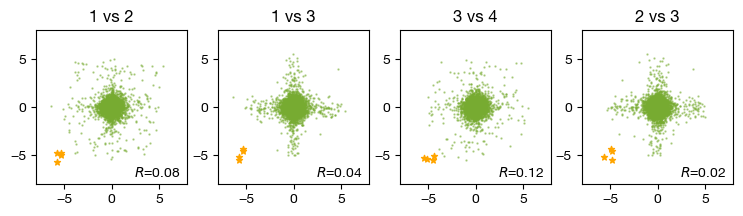

log ratio range: 0.300
introns: 3706


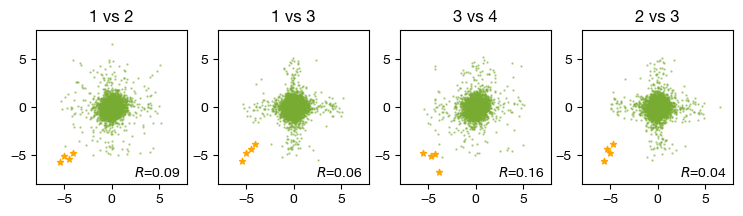

log ratio range: 0.500
introns: 3651


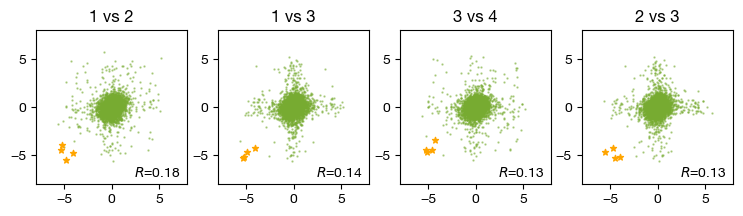

actual data:
introns: 3396


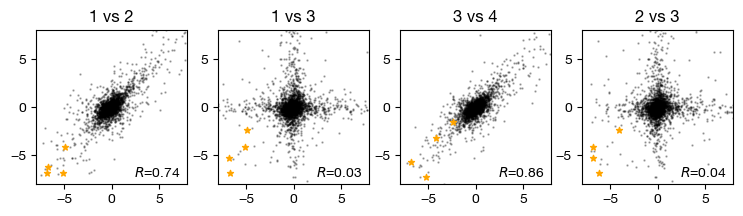

In [30]:
#plot without txf-specific noise:

noise = True
noisiness = 0.25
txf_noise = False
txf_noisiness = 1
txf_noise_sparsity = 9

ranges, filters = [0.1, 0.3, 0.5], [10]
plot_radius = 8

for filter in filters:
    print(f'read count filter = {filter}')
    for log_ratio_range in ranges:
        
        rep_s = {i:[] for i in [1,2,3,4]} 
        sim_reads_s = {i:[] for i in [1,2,3,4]}
        dTom_s = {i:0 for i in [1,2,3,4]}
        GFP_s = {i:0 for i in [1,2,3,4]}
        
        for k in range(10000):
            # generate IME score
            if k>=4:
                expected_IME = 2**(np.random.uniform(-log_ratio_range,log_ratio_range))
                p = expected_IME / (1 + expected_IME)
    
            # add intronless??
            elif k<4:
                expected_IME = 2**(np.random.normal(-5,0.2))
                p = expected_IME / (1 + expected_IME)
            
            for i in [1,3]:      
                # Generate total reads for the first pair
                if k>=4:
                    total_reads = int(random.choice(empirical_readcount_dist))
                elif k<4:
                    total_reads = int(max(empirical_readcount_dist))
    
                # simulate transfection-specific noise
                if txf_noise==True:
                    t_noise = (total_reads+1)*txf_noisiness
                    dTom_noise = random.choice([0]*5+[int(np.random.normal(0,t_noise))])
                    GFP_noise = random.choice([0]*5+[int(np.random.normal(0,t_noise))])
                else:
                    dTom_noise , GFP_noise = 0, 0
                
                # From this total readcount, sample dTomato reads based on the expected ratio
                dTom_s[i] = dTom_s[i+1] = max(0,np.random.binomial(n=total_reads, p=(1-p))+dTom_noise)
                
                # Sample foreground reads independently for rep1 and rep2
                GFP_s[i] =GFP_s[i+1] =  max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                #GFP[i+1] = max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                
                # store readcounts for filtering later
                sim_reads_s[i].append(GFP_s[i]+dTom_s[i])
                sim_reads_s[i+1].append(GFP_s[i+1]+dTom_s[i+1])
                
                # calculate and store IME scores
                rep_s[i].append(simulate_read_counts(GFP_s[i],dTom_s[i]))
                rep_s[i+1].append(simulate_read_counts(GFP_s[i+1],dTom_s[i+1]))
    
        # filter simulation data the same way i filter actual data
        mask=(np.array(sim_reads_s[1])>filter)&(np.array(sim_reads_s[2])>filter)&(np.array(sim_reads_s[3])>filter)&(np.array(sim_reads_s[4])>filter)
        
        for i in [1,2,3,4]:
            rep_s[i] = np.array(rep_s[i])
    
        coefs = []
        for i,j in [(1,2),(3,4),(1,3),(1,4),(2,3),(2,4)]:
            coef, _ = scipy.stats.pearsonr(rep_s[i][mask],rep_s[j][mask])
            coefs.append(coef)
                                                       
        print(f'log ratio range: {log_ratio_range:.3f}')
        print(f'introns: {len(rep_s[1][mask])}')
        
        # plot results of simulation
        plt.figure(figsize=(9,2))
        for i,j,k in [(1,2,1),(1,3,2),(2,3,4),(3,4,3)]:
            plt.subplot(1,4,k); plt.title(f"{i} vs {j}");plt.scatter(rep_s[i][mask], rep_s[j][mask], s=0.5, alpha=0.5, color=nicecolors(3,10))
            plt.xlim(-plot_radius,plot_radius);plt.ylim(-plot_radius,plot_radius)
            add_Rvalue(rep_s[i][mask], rep_s[j][mask])
            # add "intless"
            plt.scatter(rep_s[i][mask][:4], rep_s[j][mask][:4], s=20, marker='*', c='orange')
        plt.show()
    
    # plot actual data for comparison
    rep_s[1], rep_s[2], rep_s[3], rep_s[4] = raw_IME_scores[:,5], raw_IME_scores[:,6], raw_IME_scores[:,7], raw_IME_scores[:,8]
    mask = (readcounts[:,5]>filter)&(readcounts[:,6]>filter)&(readcounts[:,7]>filter)&(readcounts[:,8]>filter)
    print('actual data:')
    print(f'introns: {len(rep_s[1][mask])}')

    plt.figure(figsize=(9,2))
    for i,j,k in [(1,2,1),(3,4,3),(1,3,2),(2,3,4)]:
        plt.subplot(1,4,k); plt.title(f"{i} vs {j}");plt.scatter(rep_s[i][mask], rep_s[j][mask], s=0.5, alpha=0.3, color='black')
        plt.xlim(-plot_radius,plot_radius);plt.ylim(-plot_radius,plot_radius)
        add_Rvalue(rep_s[i][mask], rep_s[j][mask])
        add_intless(rep_s[i], rep_s[j])
    plt.show()


read count filter = 10
log ratio range: 0.100
introns: 3609


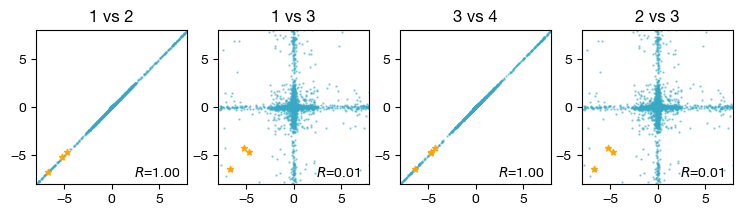

log ratio range: 0.300
introns: 3628


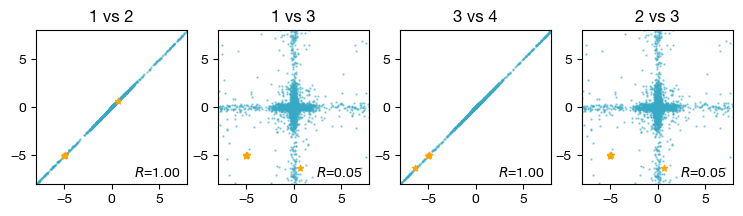

log ratio range: 0.500
introns: 3682


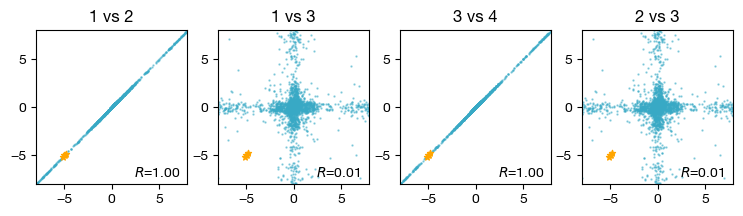

actual data:
introns: 3396


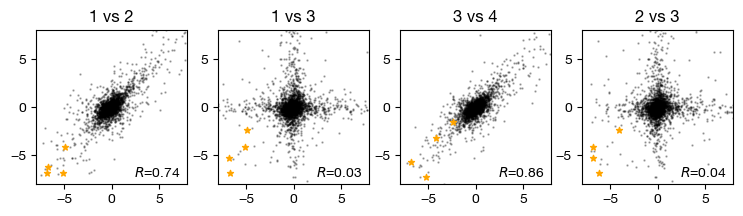

In [28]:
#plot with only txf-specific noise:

noise = False
noisiness = 0.25
txf_noise = True
txf_noisiness = 1
txf_noise_sparsity = 9

ranges, filters = [0.1, 0.3, 0.5], [10]
plot_radius = 8

for filter in filters:
    print(f'read count filter = {filter}')
    for log_ratio_range in ranges:
        
        rep_s = {i:[] for i in [1,2,3,4]} 
        sim_reads_s = {i:[] for i in [1,2,3,4]}
        dTom_s = {i:0 for i in [1,2,3,4]}
        GFP_s = {i:0 for i in [1,2,3,4]}
        
        for k in range(10000):
            # generate IME score
            if k>=4:
                expected_IME = 2**(np.random.uniform(-log_ratio_range,log_ratio_range))
                p = expected_IME / (1 + expected_IME)
    
            # add intronless??
            elif k<4:
                expected_IME = 2**(np.random.normal(-5,0.2))
                p = expected_IME / (1 + expected_IME)
            
            for i in [1,3]:      
                # Generate total reads for the first pair
                if k>=4:
                    total_reads = int(random.choice(empirical_readcount_dist))
                elif k<4:
                    total_reads = int(max(empirical_readcount_dist))
    
                # simulate transfection-specific noise
                if txf_noise==True:
                    t_noise = (total_reads+1)*txf_noisiness
                    dTom_noise = random.choice([0]*5+[int(np.random.normal(0,t_noise))])
                    GFP_noise = random.choice([0]*5+[int(np.random.normal(0,t_noise))])
                else:
                    dTom_noise , GFP_noise = 0, 0
                
                # From this total readcount, sample dTomato reads based on the expected ratio
                dTom_s[i] = dTom_s[i+1] = max(0,np.random.binomial(n=total_reads, p=(1-p))+dTom_noise)
                
                # Sample foreground reads independently for rep1 and rep2
                GFP_s[i] =GFP_s[i+1] =  max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                #GFP[i+1] = max(0,np.random.binomial(n=total_reads, p=p)+GFP_noise)
                
                # store readcounts for filtering later
                sim_reads_s[i].append(GFP_s[i]+dTom_s[i])
                sim_reads_s[i+1].append(GFP_s[i+1]+dTom_s[i+1])
                
                # calculate and store IME scores
                rep_s[i].append(simulate_read_counts(GFP_s[i],dTom_s[i]))
                rep_s[i+1].append(simulate_read_counts(GFP_s[i+1],dTom_s[i+1]))
    
        # filter simulation data the same way i filter actual data
        mask=(np.array(sim_reads_s[1])>filter)&(np.array(sim_reads_s[2])>filter)&(np.array(sim_reads_s[3])>filter)&(np.array(sim_reads_s[4])>filter)
        
        for i in [1,2,3,4]:
            rep_s[i] = np.array(rep_s[i])
    
        coefs = []
        for i,j in [(1,2),(3,4),(1,3),(1,4),(2,3),(2,4)]:
            coef, _ = scipy.stats.pearsonr(rep_s[i][mask],rep_s[j][mask])
            coefs.append(coef)
                                                       
        print(f'log ratio range: {log_ratio_range:.3f}')
        print(f'introns: {len(rep_s[1][mask])}')
        
        # plot results of simulation
        plt.figure(figsize=(9,2))
        for i,j,k in [(1,2,1),(1,3,2),(2,3,4),(3,4,3)]:
            plt.subplot(1,4,k); plt.title(f"{i} vs {j}");plt.scatter(rep_s[i][mask], rep_s[j][mask], s=0.5, alpha=0.5, color=nicecolors(6,10))
            plt.xlim(-plot_radius,plot_radius);plt.ylim(-plot_radius,plot_radius)
            add_Rvalue(rep_s[i][mask], rep_s[j][mask])
            # add "intless"
            plt.scatter(rep_s[i][mask][:4], rep_s[j][mask][:4], s=20, marker='*', c='orange')
        plt.show()
    
    # plot actual data for comparison
    rep_s[1], rep_s[2], rep_s[3], rep_s[4] = raw_IME_scores[:,5], raw_IME_scores[:,6], raw_IME_scores[:,7], raw_IME_scores[:,8]
    mask = (readcounts[:,5]>filter)&(readcounts[:,6]>filter)&(readcounts[:,7]>filter)&(readcounts[:,8]>filter)
    print('actual data:')
    print(f'introns: {len(rep_s[1][mask])}')

    plt.figure(figsize=(9,2))
    for i,j,k in [(1,2,1),(3,4,3),(1,3,2),(2,3,4)]:
        plt.subplot(1,4,k); plt.title(f"{i} vs {j}");plt.scatter(rep_s[i][mask], rep_s[j][mask], s=0.5, alpha=0.3, color='black')
        plt.xlim(-plot_radius,plot_radius);plt.ylim(-plot_radius,plot_radius)
        add_Rvalue(rep_s[i][mask], rep_s[j][mask])
        add_intless(rep_s[i], rep_s[j])
    plt.show()
